In [1]:
# Libraries
import cartopy.crs as ccrs          
import glob                        
import matplotlib.pyplot as plt     
import matplotlib.ticker as mticker 
import numpy as np                  
import os                          
import warnings                     
import xarray as xr                 
import eumartools                  


plt.rcParams.update({'font.size': 12})

In [2]:
SAFE_directory = r"C:\MSc\THESIS\COPERNICUS_DATA\unzipped\S3B_OL_2_WFR____20220419T101543_20220419T101843_20220420T224409_0179_065_065_1980_MAR_O_NT_003\S3B_OL_2_WFR____20220419T101543_20220419T101843_20220420T224409_0179_065_065_1980_MAR_O_NT_003.SEN3"

In [3]:
grid_reduce = 5

In [4]:
# Open the geo_coordinates file safely
geo_file = os.path.join(SAFE_directory, "geo_coordinates.nc")
geo_ds = xr.open_dataset(geo_file)

# Extract lat/lon arrays
lat = geo_ds['latitude'].data[::grid_reduce, ::grid_reduce]
lon = geo_ds['longitude'].data[::grid_reduce, ::grid_reduce]


In [5]:
band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'chl*.nc')))
band_vars["CHL_DIFF"] = 10**band_vars['CHL_OC4ME'] - 10**band_vars['CHL_NN']

In [6]:
flag_file = os.path.join(SAFE_directory,'wqsf.nc')
flag_vars = xr.open_dataset(flag_file)
flag_vars.close()
band_vars["WQSF"] = flag_vars["WQSF"]

ii = np.argsort(flag_vars["WQSF"].flag_masks)
bitvals = np.array(flag_vars["WQSF"].flag_masks)[ii]
meanings = np.array(flag_vars["WQSF"].flag_meanings.split(' '))[ii]

print("Bit   Bitval                 BitMeaning")
for bitval, meaning, bit in zip(bitvals, meanings, np.arange(len(bitvals))):
    print(f"{str(bit).zfill(2)}    {str(bitval).zfill(20)}   {meaning}")

Bit   Bitval                 BitMeaning
00    00000000000000000001   INVALID
01    00000000000000000002   WATER
02    00000000000000000004   LAND
03    00000000000000000008   CLOUD
04    00000000000000000016   SNOW_ICE
05    00000000000000000032   INLAND_WATER
06    00000000000000000064   COASTLINE
07    00000000000000000128   TIDAL
08    00000000000000000256   COSMETIC
09    00000000000000000512   SUSPECT
10    00000000000000001024   HISOLZEN
11    00000000000000002048   SATURATED
12    00000000000000004096   MEGLINT
13    00000000000000008192   HIGHGLINT
14    00000000000000016384   WHITECAPS
15    00000000000000032768   ADJAC
16    00000000000000065536   WV_FAIL
17    00000000000000131072   PAR_FAIL
18    00000000000000262144   AC_FAIL
19    00000000000000524288   OC4ME_FAIL
20    00000000000001048576   OCNN_FAIL
21    00000000000002097152   KDM_FAIL
22    00000000000004194304   TURBID_ATM
23    00000000000008388608   CLOUD_AMBIGUOUS
24    00000000000016777216   CLOUD_MARGIN
25    0

In [7]:
# reading masks: example land
land_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND'])
land_mask = land_mask.astype(float)[::grid_reduce, ::grid_reduce]
land_mask[land_mask == 0.0] = np.nan

In [8]:
 # reading masks: example cloud
cloud_mask = eumartools.flag_mask(flag_file, 'WQSF', ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN'])
cloud_mask = cloud_mask.astype(float)[::grid_reduce, ::grid_reduce]
cloud_mask[cloud_mask == 0.0] = np.nan

In [9]:
# reading masks: all flags BAC recommended
BAC_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3',
                                                    'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8',
                                                    'OC4ME_FAIL'])
BAC_mask = BAC_mask.astype(float)[::grid_reduce, ::grid_reduce]
BAC_mask[BAC_mask == 0.0] = np.nan

In [10]:
# reading masks: all flags NN recommended
NN_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3',
                                                    'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8',
                                                    'OCNN_FAIL'])
NN_mask = NN_mask.astype(float)[::grid_reduce, ::grid_reduce]
NN_mask[NN_mask == 0.0] = np.nan

In [16]:
print(id(cloud_mask), id(land_mask), id(BAC_mask), id(NN_mask))


2152353813712 2152353812368 2152353813808 2152353814288


In [17]:
print("cloud == land:", np.array_equal(cloud_mask, land_mask))
print("cloud == BAC:", np.array_equal(cloud_mask, BAC_mask))
print("cloud == NN:", np.array_equal(cloud_mask, NN_mask))
print("land == BAC:", np.array_equal(land_mask, BAC_mask))
print("BAC == NN:", np.array_equal(BAC_mask, NN_mask))


cloud == land: False
cloud == BAC: False
cloud == NN: False
land == BAC: False
BAC == NN: False


In [20]:
print("Masked by cloud:", np.count_nonzero(~np.isnan(cloud_mask)))
print("Masked by land:", np.count_nonzero(~np.isnan(land_mask)))
print("Masked by BAC:", np.count_nonzero(~np.isnan(BAC_mask)))
print("Masked by NN:", np.count_nonzero(~np.isnan(NN_mask)))


Masked by cloud: 302776
Masked by land: 241174
Masked by BAC: 571847
Masked by NN: 585475


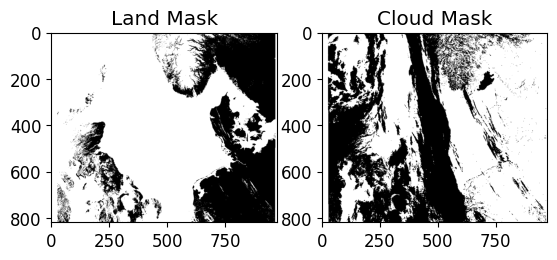

In [11]:
# Plot masks
plt.subplot(1, 2, 1)
plt.imshow(land_mask, cmap='gray')
plt.title('Land Mask')

plt.subplot(1, 2, 2)
plt.imshow(cloud_mask, cmap='gray')
plt.title('Cloud Mask')
plt.savefig('mask.png', bbox_inches='tight')
plt.show()

In [22]:
overlap = np.logical_and(land_mask == 1, cloud_mask == 1)
percent_overlap = np.count_nonzero(overlap) / np.count_nonzero(land_mask == 1) * 100
print(f"{percent_overlap:.2f}% of land-masked pixels are also cloud-masked.")


14.85% of land-masked pixels are also cloud-masked.


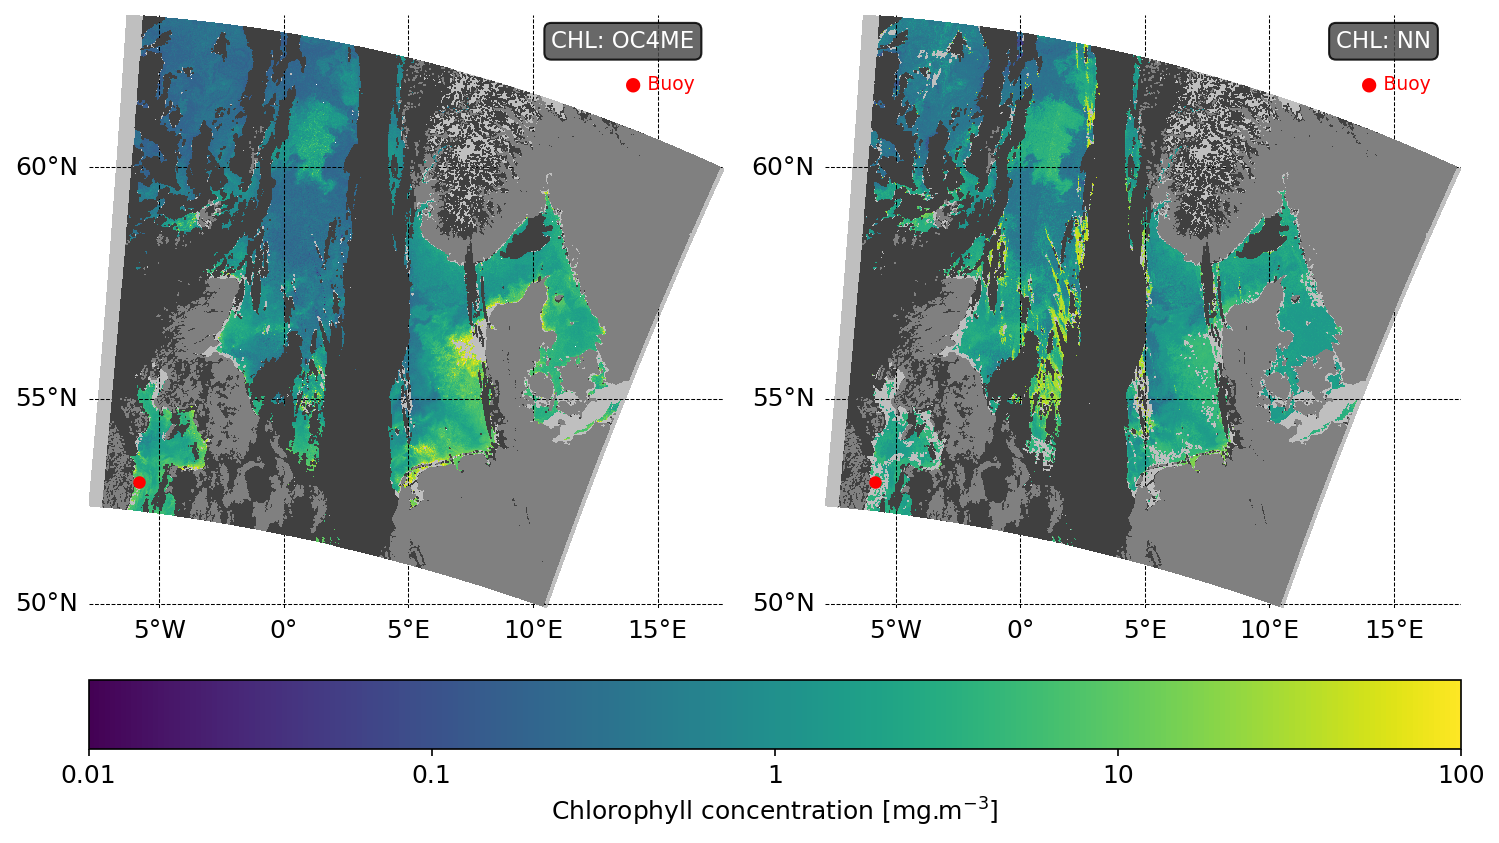

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=150, subplot_kw={"projection": ccrs.Mercator()})

for m, var, cmap, all_mask in zip(axs.reshape(-1),
                         ['CHL_OC4ME', 'CHL_NN'],
                         ['viridis','viridis'],[BAC_mask, NN_mask]):
    
    # band_vars[var] contains CHL in mg m^-3 (not logged)
    p1 = m.pcolormesh(lon, lat, band_vars[var][::grid_reduce, ::grid_reduce],
                  transform=ccrs.PlateCarree(),
                  cmap='viridis', vmin=-2, vmax=2, zorder=1, shading='auto')

    m.contourf(lon, lat, all_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
    m.contourf(lon, lat, cloud_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.25', zorder=3)
    m.contourf(lon, lat, land_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5', zorder=4)

    # m.annotate(f"{var.replace('_',': ')}", xy=(0.1, 0.75), xycoords='axes fraction',
    #         transform=ccrs.PlateCarree(), zorder=30, color='w')

    # Embellish with gridlines
    g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
    g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
    g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    m.set(facecolor = "1.0")
    m.axis('off')

# Add red dot for seabed frame
frame_lat = 53 + 2.888 / 60          # ≈ 53.0481
frame_lon = -(5 + 49.985 / 60)       # ≈ -5.8324
for m in axs:
    m.plot(frame_lon, frame_lat, 'ro', markersize=5, transform=ccrs.PlateCarree(), zorder=5)

plt.tight_layout()

# Colorbar
cbar = fig.colorbar(p1, ax=axs[:], location='bottom', pad=0.05)
ticks = [-2, -1, 0, 1, 2]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**tick for tick in ticks])
cbar.set_label('Chlorophyll concentration [mg.m$^{-3}$]')

# Add external panel labels (top-right above each map)
for ax, txt in zip(axs, ["CHL: OC4ME", "CHL: NN"]):
    bb = ax.get_position()
    x  = bb.x1 - 0.02
    y  = bb.y1 - 0.01
    
    # Main grey label
    fig.text(x, y, txt,
             ha='right', va='top', fontsize=11, color='w',
             bbox=dict(facecolor='0.30', alpha=0.85, boxstyle='round,pad=0.3'))
    
    # "Buoy" label under it with a red dot
    fig.text(x, y - 0.03, u"\u25CF Buoy",  # red circle + text
             ha='right', va='top', fontsize=9, color='red')
plt.savefig('1_6_OLCI_CHL.png', bbox_inches='tight')

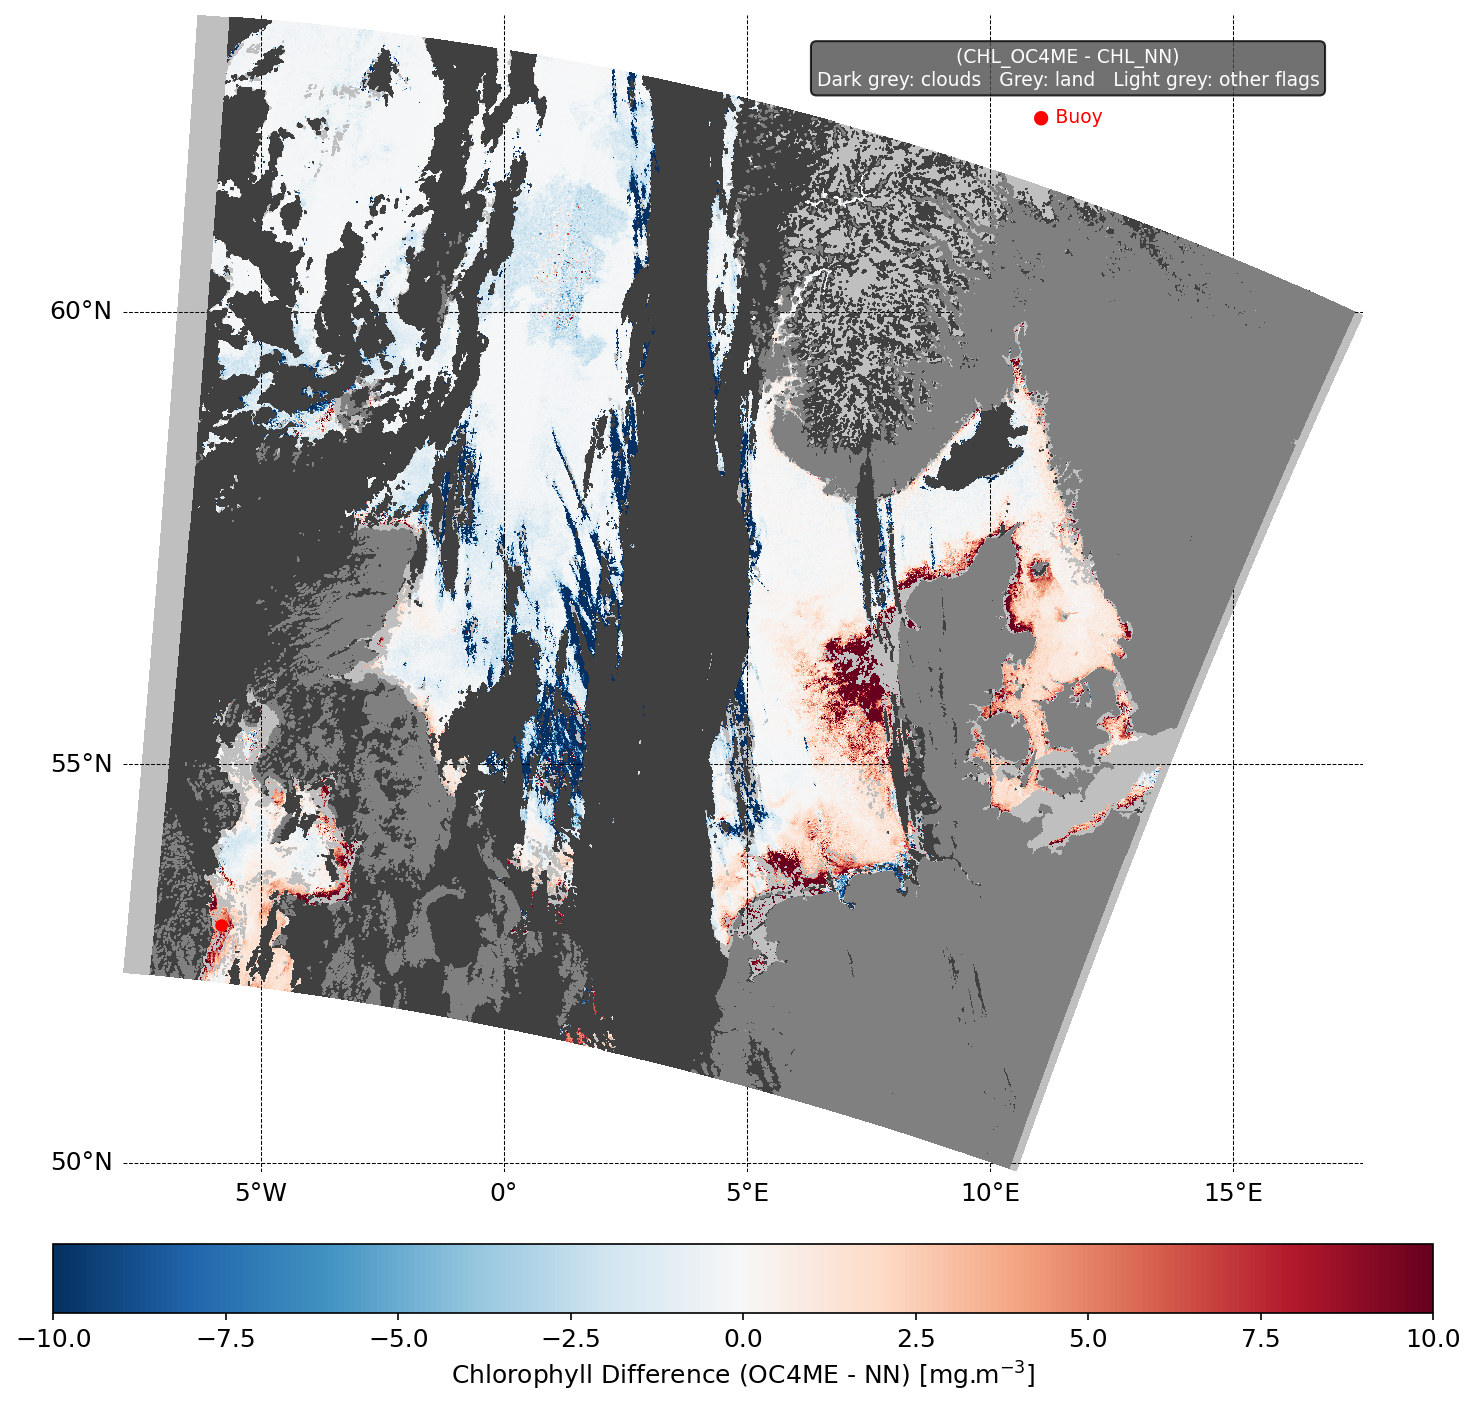

In [83]:
fig = plt.figure(figsize=(10, 10), dpi=150)
m = plt.subplot(projection=ccrs.Mercator())
 
p1 = m.pcolormesh(lon, lat, band_vars["CHL_DIFF"][::grid_reduce, ::grid_reduce], transform=ccrs.PlateCarree(), 
                   cmap=plt.cm.RdBu_r, vmin=-10, vmax=10, zorder=1)

m.contourf(lon, lat, BAC_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
m.contourf(lon, lat, NN_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
m.contourf(lon, lat, cloud_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.25', zorder=3)
m.contourf(lon, lat, land_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5', zorder=4)

fig.text(
    0.72, 0.96,
    "(CHL_OC4ME - CHL_NN)\nDark grey: clouds   Grey: land   Light grey: other flags",
    ha='center', va='top',
    fontsize=9, color='w',
    bbox=dict(facecolor='0.3', alpha=0.8, boxstyle='round,pad=0.3')
)

# Buoy
fig.text(
    0.72, 0.92,  # slightly lower Y position
    u"\u25CF Buoy",
    ha='center', va='top',
    fontsize=9, color='red'
)


# gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set(facecolor = "1.0")
m.axis('off')

# Add nuoy
frame_lat = 53 + 2.888 / 60
frame_lon = -(5 + 49.985 / 60)
m.plot(frame_lon, frame_lat, 'ro', markersize=5, transform=ccrs.PlateCarree(), zorder=5)

cbar = fig.colorbar(p1, location='bottom', pad=0.05)
cbar.set_label('Chlorophyll Difference (OC4ME - NN) [mg.m$^{-3}$]')
plt.tight_layout()
plt.savefig('1_6_OLCI_CHL_diff.png', bbox_inches='tight')

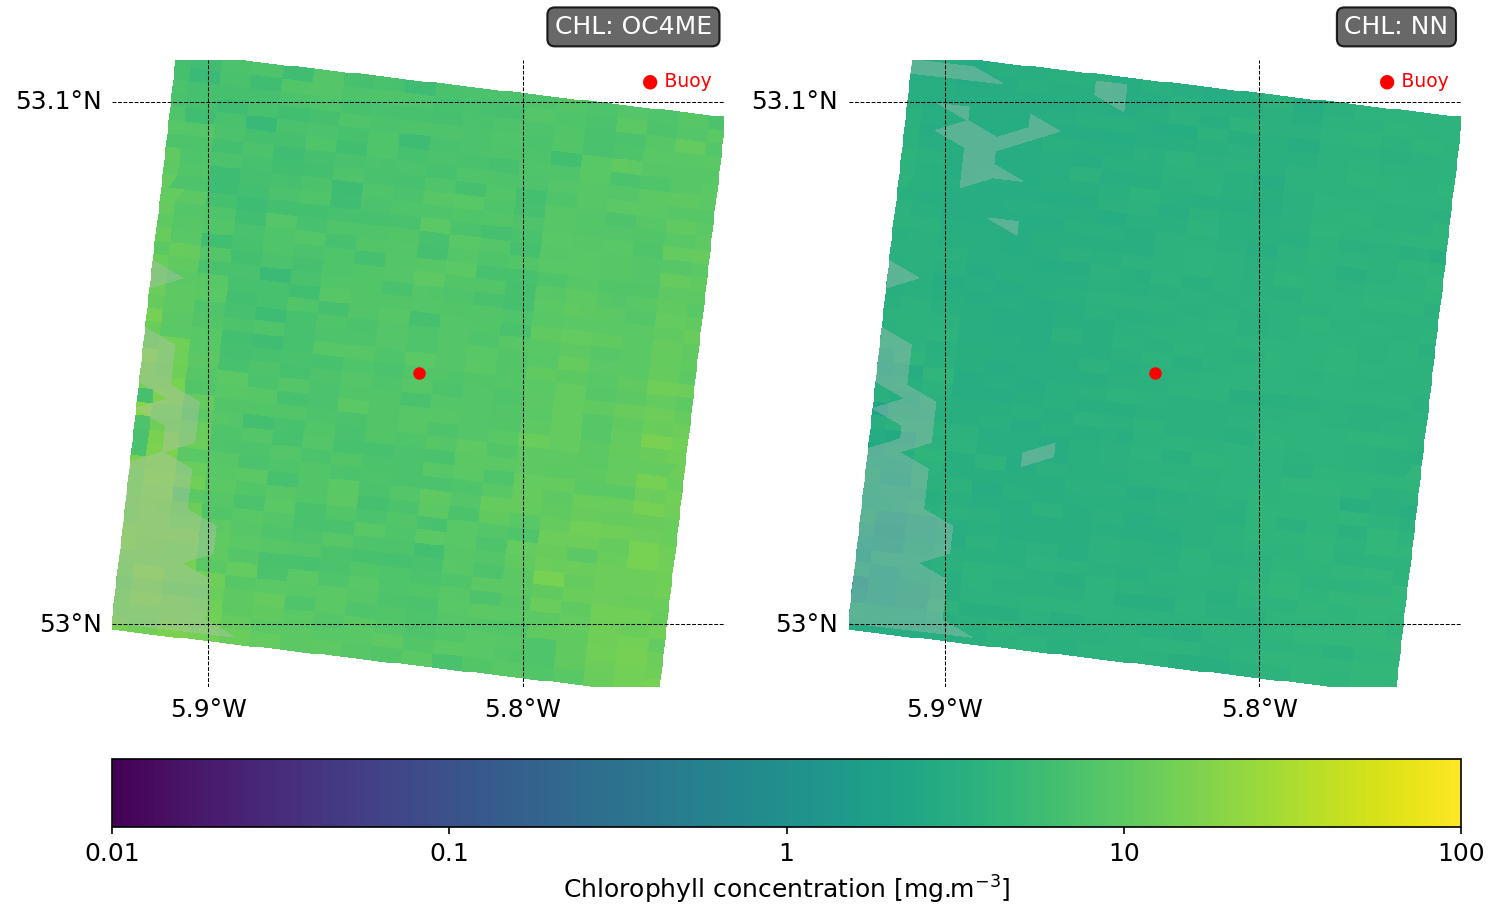

In [84]:
import os, glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import eumartools

# Configuration
SAFE_directory = r"C:\MSc\THESIS\COPERNICUS_DATA\unzipped\S3B_OL_2_WFR____20220419T101543_20220419T101843_20220420T224409_0179_065_065_1980_MAR_O_NT_003\S3B_OL_2_WFR____20220419T101543_20220419T101843_20220420T224409_0179_065_065_1980_MAR_O_NT_003.SEN3"
frame_lat = 53 + 2.888 / 60.0      # 53.0481
frame_lon = -(5 + 49.985 / 60.0)   # -5.8324
zoom_km   = 5.0                     
preserve_tilt = False               


# ---------- load FULL-RES lon/lat ----------
geo_file = os.path.join(SAFE_directory, "geo_coordinates.nc")
geo_ds = xr.open_dataset(geo_file)
lon_full = geo_ds["longitude"].data
lat_full = geo_ds["latitude" ].data

# Chl(log10) 
chl_files = glob.glob(os.path.join(SAFE_directory, "chl*.nc"))
band_vars = xr.open_mfdataset(chl_files, combine="by_coords")
chl_oc4 = band_vars["CHL_OC4ME"].data  # log10
chl_nn  = band_vars["CHL_NN"   ].data  # log10

# ---------- full-res masks from WQSF ----------
flag_file = os.path.join(SAFE_directory, "wqsf.nc")

# BAC (OC4ME) mask
BAC_full = eumartools.flag_mask(
    flag_file, "WQSF",
    ['LAND','CLOUD','CLOUD_AMBIGUOUS','CLOUD_MARGIN',
     'INVALID','COSMETIC','SATURATED','SUSPECT',
     'HISOLZEN','HIGHGLINT','SNOW_ICE','AC_FAIL',
     'WHITECAPS','ADJAC','RWNEG_O2','RWNEG_O3',
     'RWNEG_O4','RWNEG_O5','RWNEG_O6','RWNEG_O7','RWNEG_O8',
     'OC4ME_FAIL']
).astype(float)
BAC_full[BAC_full == 0.0] = np.nan

# AC (NN) mask
NN_full = eumartools.flag_mask(
    flag_file, "WQSF",
    ['LAND','CLOUD','CLOUD_AMBIGUOUS','CLOUD_MARGIN',
     'INVALID','COSMETIC','SATURATED','SUSPECT',
     'HISOLZEN','HIGHGLINT','SNOW_ICE','AC_FAIL',
     'WHITECAPS','ADJAC','RWNEG_O2','RWNEG_O3',
     'RWNEG_O4','RWNEG_O5','RWNEG_O6','RWNEG_O7','RWNEG_O8',
     'OCNN_FAIL']
).astype(float)
NN_full[NN_full == 0.0] = np.nan

cloud_full = eumartools.flag_mask(flag_file, "WQSF",
                                  ['CLOUD','CLOUD_AMBIGUOUS','CLOUD_MARGIN']).astype(float)
cloud_full[cloud_full == 0.0] = np.nan
land_full  = eumartools.flag_mask(flag_file, "WQSF", ['LAND']).astype(float)
land_full[land_full == 0.0] = np.nan

# Plot
def plot_zoom_fullres_two_panel(lon_full, lat_full,
                                chl_oc4_full, chl_nn_full,
                                bac_full, nnmask_full, cloud_full, land_full,
                                frame_lon, frame_lat,
                                zoom_km=5.0, preserve_tilt=False, save=None):

    # window in degrees around the buoy
    deg_lat = zoom_km / 111.0
    deg_lon = zoom_km / (111.0 * np.cos(np.deg2rad(frame_lat)))
    lon_min, lon_max = frame_lon - deg_lon, frame_lon + deg_lon
    lat_min, lat_max = frame_lat - deg_lat, frame_lat + deg_lat

    # indices for the zoom window
    win = (lon_full >= lon_min) & (lon_full <= lon_max) & \
          (lat_full >= lat_min) & (lat_full <= lat_max)
    rows, cols = np.where(win)
    if rows.size == 0 or cols.size == 0:
        raise RuntimeError("Zoom window has no cells — increase zoom_km or check lon/lat.")

    pad = 2
    r0, r1 = max(0, rows.min()-pad), min(lon_full.shape[0]-1, rows.max()+pad)
    c0, c1 = max(0, cols.min()-pad), min(lon_full.shape[1]-1, cols.max()+pad)

    # full-res slices
    lonZ   = lon_full   [r0:r1+1, c0:c1+1]
    latZ   = lat_full   [r0:r1+1, c0:c1+1]
    oc4Z   = chl_oc4_full[r0:r1+1, c0:c1+1]
    nnZ    = chl_nn_full [r0:r1+1, c0:c1+1]
    bacZ   = bac_full    [r0:r1+1, c0:c1+1]
    nnmZ   = nnmask_full [r0:r1+1, c0:c1+1]
    cloudZ = cloud_full  [r0:r1+1, c0:c1+1]
    landZ  = land_full   [r0:r1+1, c0:c1+1]

    fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=150,
                            subplot_kw={"projection": ccrs.Mercator()})

    # plot the two maps
    last_quad = None
    for ax, dataZ, maskZ in zip(axs, [oc4Z, nnZ], [bacZ, nnmZ]):
        last_quad = ax.pcolormesh(lonZ, latZ, dataZ, transform=ccrs.PlateCarree(),
                                  cmap='viridis', vmin=-2, vmax=2, shading='auto', zorder=1)

        ax.contourf(lonZ, latZ, maskZ,   levels=[0,1], transform=ccrs.PlateCarree(),
                    colors='0.75', alpha=0.35, zorder=2)
        ax.contourf(lonZ, latZ, cloudZ,  levels=[0,1], transform=ccrs.PlateCarree(),
                    colors='0.25', alpha=0.35, zorder=3)
        ax.contourf(lonZ, latZ, landZ,   levels=[0,1], transform=ccrs.PlateCarree(),
                    colors='0.5',  alpha=0.45, zorder=4)

        ax.set_extent([lonZ.min(), lonZ.max(), latZ.min(), latZ.max()],
                      crs=ccrs.PlateCarree())

        gl = ax.gridlines(draw_labels=True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 0.1))
        gl.ylocator = mticker.FixedLocator(np.arange(-90,   90,  0.1))
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'color': 'black'}
        gl.ylabel_style = {'color': 'black'}

        # buoy dot on the map
        ax.plot(frame_lon, frame_lat, 'ro', markersize=5, transform=ccrs.PlateCarree(), zorder=5)
        ax.set(facecolor="1.0"); ax.axis('off')

    
    plt.tight_layout()
    fig.canvas.draw()

    
    labels  = ["CHL: OC4ME", "CHL: NN"]


    label_offset = (-6, 10)   
    buoy_offset  = (-6, -6)  

    for ax, txt in zip(axs, labels):
    # Grey panel label 
        ax.annotate(
            txt,
            xy=(1, 1), xycoords='axes fraction',   # top-right of the axes
            xytext=label_offset, textcoords='offset points',
            ha='right', va='bottom', color='w',
            bbox=dict(facecolor='0.30', alpha=0.85, boxstyle='round,pad=0.3'),
            zorder=50,
        )

        ax.annotate(
            u"\u25CF Buoy",
            xy=(1, 1), xycoords='axes fraction',
            xytext=buoy_offset, textcoords='offset points',
            ha='right', va='top', color='red', fontsize=9, zorder=50,
        )

    # colourbar
    cbar = fig.colorbar(last_quad, ax=axs[:], location='bottom', pad=0.05)
    ticks = [-2, -1, 0, 1, 2]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([10**t for t in ticks])
    cbar.set_label('Chlorophyll concentration [mg.m$^{-3}$]')

    if save:
        plt.savefig(save, bbox_inches='tight', dpi=150)
    plt.show()

# Call function to plot
plot_zoom_fullres_two_panel(
    lon_full, lat_full,
    chl_oc4, chl_nn,
    BAC_full, NN_full, cloud_full, land_full,
    frame_lon, frame_lat,
    zoom_km=zoom_km,
    preserve_tilt=False,                 
    save='OLCI_zoom_fullres.png'
)


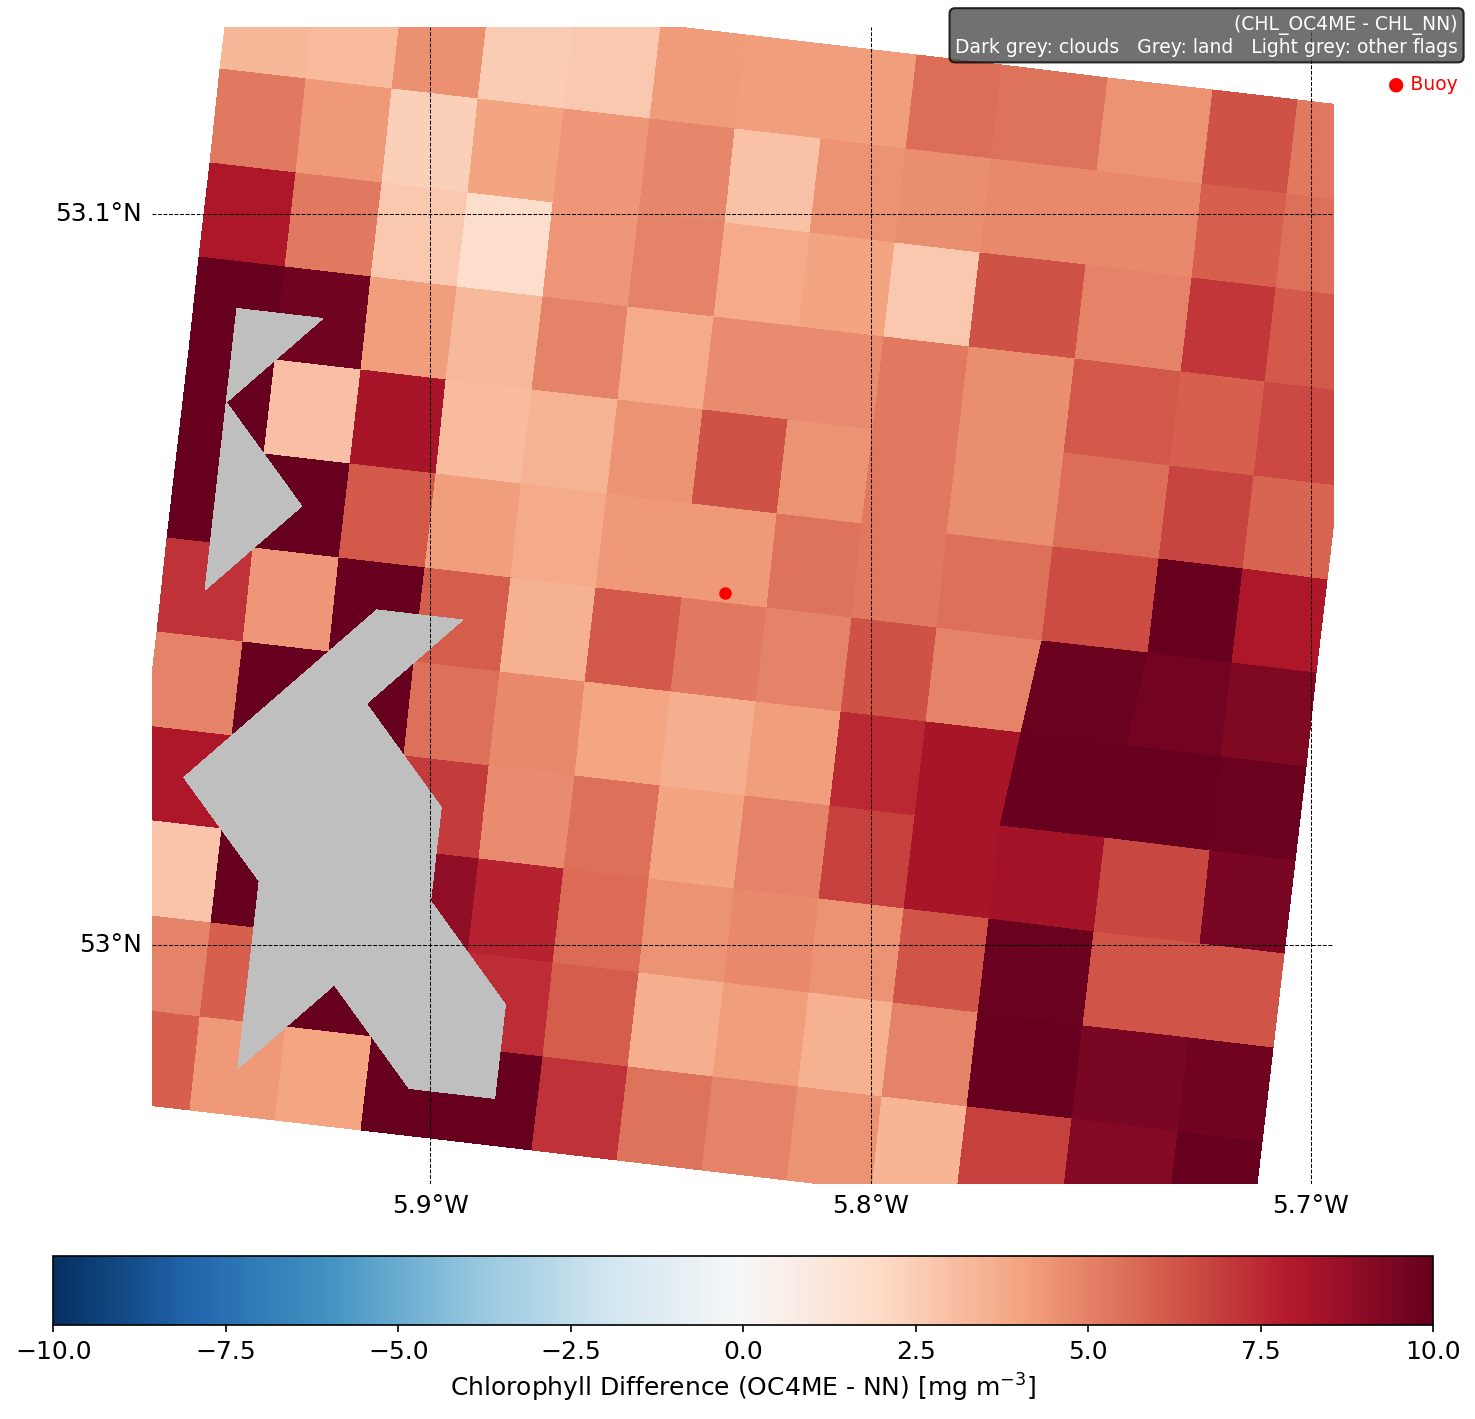

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'chl*.nc')))
band_vars["CHL_DIFF"] = 10**band_vars['CHL_OC4ME'] - 10**band_vars['CHL_NN']

def plot_diff_zoom(
    lon, lat, diff_log10,          
    BAC_mask, NN_mask, cloud_mask, land_mask,
    frame_lon, frame_lat,
    zoom_km=5.0,                   
    preserve_tilt=False,          
    save=None
):
    """
    Zoomed 'CHL_OC4ME - CHL_NN' plot, with masks and buoy.
    This function assumes lon/lat and all masks have the same shape as diff_log10.
    """

    # Find window
    deg_lat = zoom_km / 111.0
    deg_lon = zoom_km / (111.0 * np.cos(np.deg2rad(frame_lat)))
    lon_min, lon_max = frame_lon - deg_lon, frame_lon + deg_lon
    lat_min, lat_max = frame_lat - deg_lat, frame_lat + deg_lat

    # Compute padded 
    win = (lon >= lon_min) & (lon <= lon_max) & (lat >= lat_min) & (lat <= lat_max)
    rows, cols = np.where(win)
    if rows.size == 0 or cols.size == 0:
        raise RuntimeError("Zoom window has no cells.")

    pad = 2
    r0, r1 = max(0, rows.min()-pad), min(lon.shape[0]-1, rows.max()+pad)
    c0, c1 = max(0, cols.min()-pad), min(lon.shape[1]-1, cols.max()+pad)

    # Subset (same resolution as inputs)
    lonZ   = lon      [r0:r1+1, c0:c1+1]
    latZ   = lat      [r0:r1+1, c0:c1+1]
    diffZ  = diff_log10[r0:r1+1, c0:c1+1]
    bacZ   = BAC_mask [r0:r1+1, c0:c1+1]
    nnZ    = NN_mask  [r0:r1+1, c0:c1+1]
    cloudZ = cloud_mask[r0:r1+1, c0:c1+1]
    landZ  = land_mask [r0:r1+1, c0:c1+1]

    # Extend scene
    scene_extent = [float(np.nanmin(lon)), float(np.nanmax(lon)),
                    float(np.nanmin(lat)), float(np.nanmax(lat))]

    # Plot
    fig = plt.figure(figsize=(10, 10), dpi=150)
    ax  = plt.subplot(projection=ccrs.Mercator())

    p = ax.pcolormesh(
        lonZ, latZ, diffZ, transform=ccrs.PlateCarree(),
        cmap=plt.cm.RdBu_r, vmin=-10, vmax=10, shading='auto', zorder=1
    )

    # Apply masks
    ax.contourf(lonZ, latZ, bacZ,   levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
    ax.contourf(lonZ, latZ, nnZ,    levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
    ax.contourf(lonZ, latZ, cloudZ, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.25', zorder=3)
    ax.contourf(lonZ, latZ, landZ,  levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5',  zorder=4)

    fig.text(
        0.98, 0.99,  # (x, y) in fig coordinates
        "(CHL_OC4ME - CHL_NN)\nDark grey: clouds   Grey: land   Light grey: other flags",
        ha='right', va='top',
        fontsize=9, color='w',
        bbox=dict(facecolor='0.3', alpha=0.8, boxstyle='round,pad=0.3')
    )

    fig.text(
        0.98, 0.95,  
        u"\u25CF Buoy",
        ha='right', va='top',
        fontsize=9, color='red'
    )

   # Keep tilt
    if preserve_tilt:
        ax.set_extent(scene_extent, crs=ccrs.PlateCarree())
        bx = [lon_min, lon_max, lon_max, lon_min, lon_min]
        by = [lat_min, lat_min, lat_max, lat_max, lat_min]
        ax.plot(bx, by, transform=ccrs.PlateCarree(), color='w', lw=1.2, zorder=30)
    else:
        ax.set_extent([lonZ.min(), lonZ.max(), latZ.min(), latZ.max()],
                      crs=ccrs.PlateCarree())

    # Grid dot
    gl = ax.gridlines(draw_labels=True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'color': 'black'}
    gl.ylabel_style = {'color': 'black'}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 0.1))  # fewer ticks
    gl.ylocator = mticker.FixedLocator(np.arange(-90,   90,  0.1))

    ax.set(facecolor="1.0"); ax.axis('off')

    ax.plot(frame_lon, frame_lat, 'ro', markersize=5, transform=ccrs.PlateCarree(), zorder=5)

    cbar = fig.colorbar(p, ax=ax, location='bottom', pad=0.05)
    cbar.set_label('Chlorophyll Difference (OC4ME - NN) [mg m$^{-3}$]')
    plt.tight_layout()
    if save is not None:
        plt.savefig(save, bbox_inches='tight', dpi=150)
    plt.show()

# Difference plot
diff_linear = band_vars["CHL_DIFF"][::grid_reduce, ::grid_reduce].data

plot_diff_zoom(
    lon=lon, lat=lat,
    diff_log10=diff_linear,
    BAC_mask=BAC_mask, NN_mask=NN_mask, cloud_mask=cloud_mask, land_mask=land_mask,
    frame_lon=-(5 + 49.985/60), frame_lat=(53 + 2.888/60),
    zoom_km=5.0,                 # change to taste (e.g., 2, 10, …)
    preserve_tilt=False,         # True if you want to keep swath tilt
    save='OLCI_CHL_diff_zoom.png'
)
